In [5]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
import os

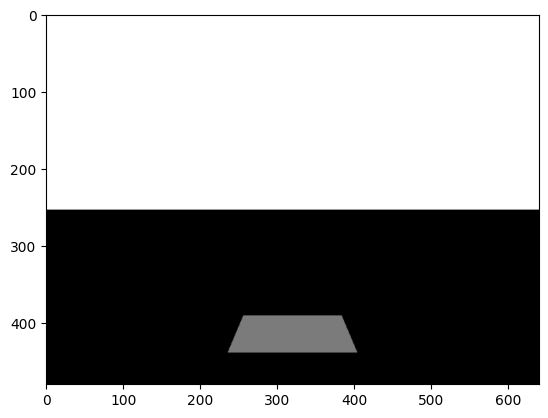

In [29]:
img = cv.imread('imgs/perspective_calibration.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap='gray')

/tmp/ipykernel_161736/3204470351.py:7: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


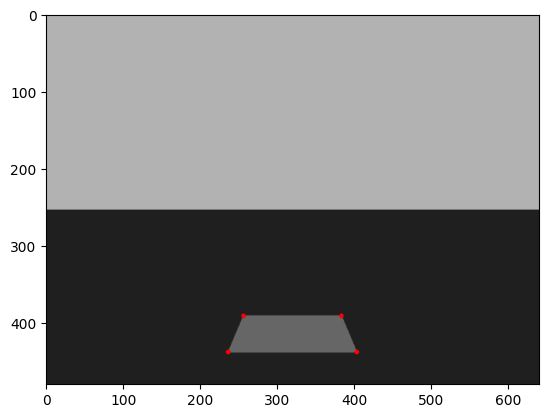

In [30]:
img = cv.imread('imgs/perspective_calibration.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

corners = cv.goodFeaturesToTrack(gray, 4, 0.01, 10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),3,255,-1)

plt.imshow(img)

In [8]:
table_corners = corners.squeeze(1)
table_corners = table_corners.astype(np.float32)
table_corners

array([[236., 438.],
       [403., 438.],
       [383., 391.],
       [256., 391.]], dtype=float32)

In [9]:
# table_corners = table_corners.T
table_corners = np.flip(table_corners, axis=0)

In [10]:
# pts_target = np.float32([[0, 0], [0, 480], [640, 0], [640, 480]])
x_size, y_size = 200, 200
y_offset = 180
box_size = 480 - y_size - x_size

pts_target = np.float32([[x_size, y_size], [480 - x_size, y_size], [480 - x_size, 480 - y_size], [x_size, 480 - y_size]])
pts_target += np.array([0, y_offset])

M = cv.getPerspectiveTransform(table_corners, pts_target)
M_inv = cv.getPerspectiveTransform(pts_target, table_corners)

In [11]:
pixel_per_meter_x = (480 - y_size * 2) / 1.
meter_per_pixel_x = 1 /( pixel_per_meter_x)
print(f'Pixel per meter: {pixel_per_meter_x} [px/m]')
print(f'Meter per pixel: {meter_per_pixel_x} [m/px]')

Pixel per meter: 80.0 [px/m]
Meter per pixel: 0.0125 [m/px]


(-0.5, 479.5, 479.5, -0.5)

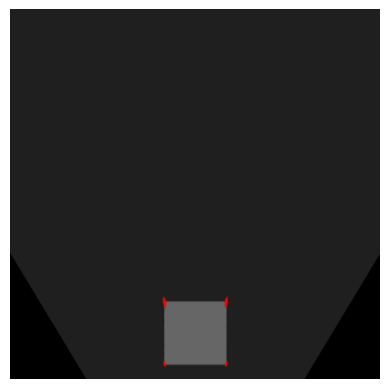

In [12]:
cal_out = cv.warpPerspective(img, M, (480, 480), flags=cv.INTER_LINEAR)
plt.imshow(cal_out)
plt.axis('off')

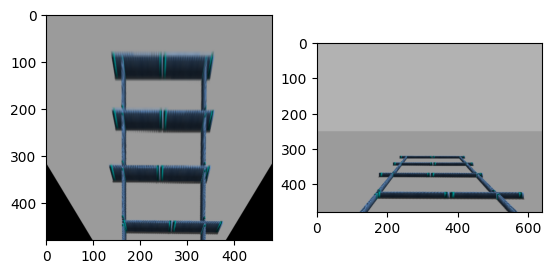

In [31]:
# img2 = cv.imread('../../ros/dev_ws/src/gazebo_sim/images/images_raw/img_00118.png')
img2 = cv.imread('imgs/image.png')

out = cv.warpPerspective(img2, M, (480, 480), flags=cv.INTER_LINEAR)
 
# Display the transformed image
fig, ax = plt.subplots(1, 2)
ax[0].imshow(out)
ax[1].imshow(img2)

#### Distance calculation
In the calibration image the center of the rectangle was 4 meters away from the base link.

(-52.75, 777.75, 519.775, -0.5)

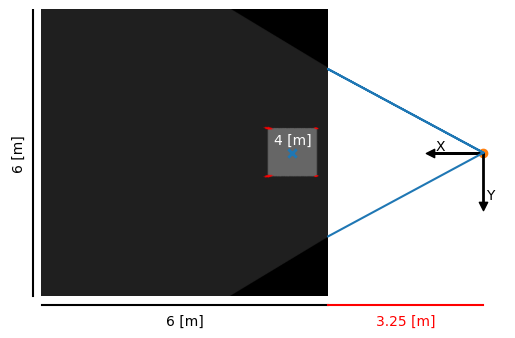

In [14]:
x_base_link_offset = 0
y_base_link_offset = 4 * pixel_per_meter_x

plt.plot([740, 650, 740, 740], [480/2, 480/2, 480/2, 480/2+90], linewidth=2, color='k') 

plt.imshow(np.rot90(cal_out))
plt.annotate('4 [m]', (480 / 2 + y_offset, 480 / 2-10), ha='center', va='bottom', color='white')
plt.scatter(480 / 2 + y_offset, 480 / 2, marker='x', linewidth=2)

# plt.scatter(0, 480 / 2, marker='x', linewidth=2)
# plt.annotate(f'{meter_per_pixel_x * (480 / 2 + y_offset + y_base_link_offset)} [m]', (0, 480 / 2-10), ha='left', va='bottom', color='white')

# plt.annotate(f'{meter_per_pixel_x * (480 / 2 + y_offset + y_base_link_offset - 480)} [m]', (480, 480/2-10), va='bottom')
# plt.scatter(480, 480 / 2, marker='x', linewidth=2)

plt.scatter(480 / 2 + y_offset + y_base_link_offset, 480 / 2, marker='o')
plt.annotate('X', (660, 480/2), va='bottom', ha='left')
plt.annotate('Y', (745, 480/2+60), va='top')
plt.scatter(650, 480/2, marker='<', color='k')
plt.scatter(740, 480/2+90, marker='v', color='k')
plt.plot([480 / 2 + y_offset + y_base_link_offset, 480, 480 / 2 + y_offset + y_base_link_offset, 480], [480 / 2, 100, 480/2, 380])

plt.plot([-15, -15], [0, 480], color='k')
plt.annotate('6 [m]', (-50, 480/2), rotation=90, va='center')
plt.plot([0, 480], [495, 495], color='k')
plt.annotate('6 [m]', (480/2, 510), va='top', ha='center')
plt.plot([480, 740], [495, 495], color='red')
plt.annotate('3.25 [m]', (480 + (740-480)/2, 510), color='red', va='top', ha='center')

plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.axis('off')

In [15]:
# create dict with all the important parameters

top_down_transform = dict(M=M, 
                          M_inv=M_inv,
                          pixel_per_meter=pixel_per_meter_x,
                          origin=(480 / 2, 480 / 2 + y_offset + y_base_link_offset))

top_down_transform

{'M': array([[-3.88791232e-01, -9.92658463e-01,  3.64218798e+02],
        [ 7.05253336e-15, -2.95315893e+00,  9.20146831e+02],
        [ 1.75664103e-17, -4.13607693e-03,  1.00000000e+00]]),
 'M_inv': array([[ 7.42612045e-01, -4.47478992e-01,  1.41273109e+02],
        [ 1.01506105e-15, -3.38620448e-01,  3.11580532e+02],
        [ 2.96059473e-18, -1.40056022e-03,  1.00000000e+00]]),
 'pixel_per_meter': 80.0,
 'origin': (240.0, 740.0)}

In [16]:
np.save('top_down_transform', np.array(top_down_transform))

In [17]:
a = np.load('top_down_transform.npy', allow_pickle=True).item()

In [18]:
a['origin']

(240.0, 740.0)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  45  47  48  49  50  52  57  60  61  62  63
  64  68  71  74  76  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 102]


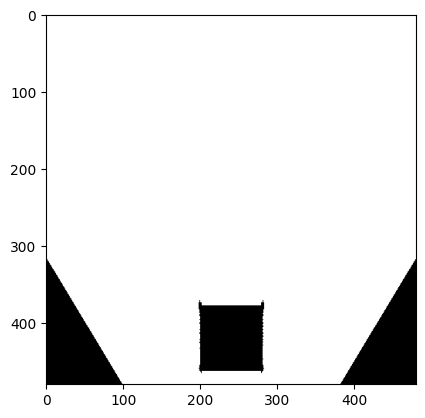

In [19]:
gray_in = cv.cvtColor(cal_out, cv.COLOR_RGB2GRAY)
print(np.unique(gray_in))
binary_mask = (gray_in == 31).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')

In [20]:
# occ_grid = image_to_occ_grid(gray_in)
occ_grid = (np.ones_like(binary_mask) - binary_mask)

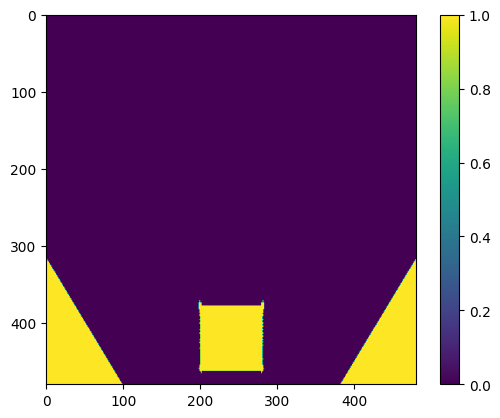

In [21]:
plt.imshow(occ_grid)
plt.colorbar()

## Local occupancy grid to global occupancy grid map

- explain

(-0.5, 479.5, 479.5, -0.5)

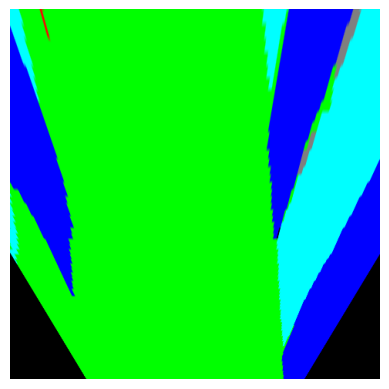

In [32]:
img_seq = []
for i in range(3):
    ing = cv.imread(f'imgs/seq{i}.png')
    ing = cv.cvtColor(ing, cv.COLOR_BGR2RGB)
    ing = cv.resize(ing, (640, 480), interpolation=cv.INTER_AREA)
    img_seq.append(cv.warpPerspective(ing, M, (480, 480), flags=cv.INTER_AREA))

plt.imshow(img_seq[0])
plt.axis('off')

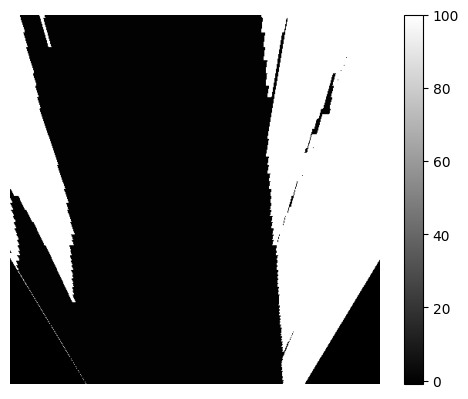

In [23]:
image = cv.cvtColor(img_seq[0], cv.COLOR_RGB2GRAY)
binary_mask = (image == 150).astype(np.uint8) + (image == 0).astype(np.uint8) 
binary_mask = binary_mask
unkown_mask = (image == 0).astype(np.uint8)

plt.imshow((100 * (np.ones_like(binary_mask) - binary_mask) - unkown_mask).astype(np.int8), cmap='gray') 
plt.axis('off')
plt.colorbar()
# plt.imshow(binary_mask)

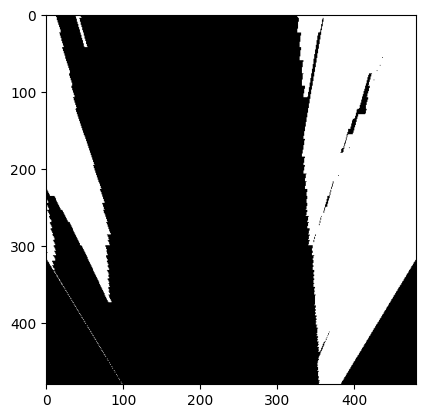

In [24]:
t = cv.cvtColor(img_seq[0], cv.COLOR_RGB2GRAY)
binary_mask = np.ones_like(t) - (t==150).astype(np.uint8)
binary_mask -= (t==0).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.show()

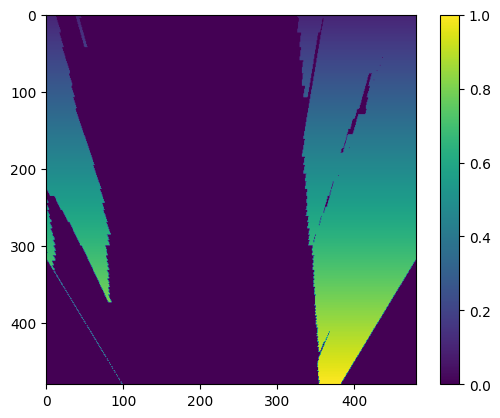

In [25]:
ponderator = np.linspace(0.1, 1, occ_grid.shape[0])
ponderator = np.tile(ponderator, (occ_grid.shape[1], 1)).T

plt.imshow(binary_mask * ponderator)
plt.colorbar()

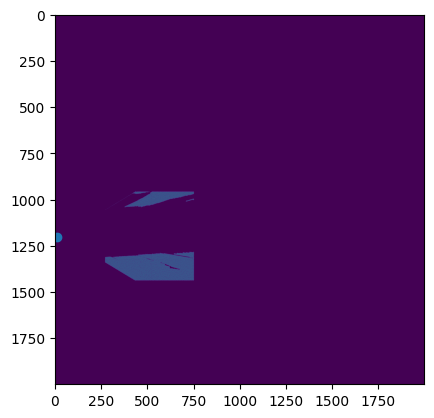

In [26]:
mapgrande = np.zeros((2000, 2000))


def update_map(input, map, pose):
    # TODO: add bounds check

    Ll, Hl = input.shape
    xR, yR, yawR = pose
    dy, dx = int(3.25 * 80), Ll // 2

    for x_ in range(Ll):
        for y_ in range(Hl):
            R = np.sqrt((Hl - y_ + dy)**2 + (x_ - dx)**2)
            phi = np.arctan2(x_ - dx, Hl - y_ + dy)

            rx = int(R * np.cos(np.radians(yawR) - phi))
            ry = int(R * np.sin(np.radians(yawR) - phi))
            
            i = xR + rx
            j = yR - ry

            map[j, i] += input[y_, x_]
            if map[j, i] > 100: map[j, i] = 100

pose = (10, 1200, 0)
update_map(binary_mask, mapgrande, pose)
plt.imshow(mapgrande)
plt.scatter(*pose[:2])

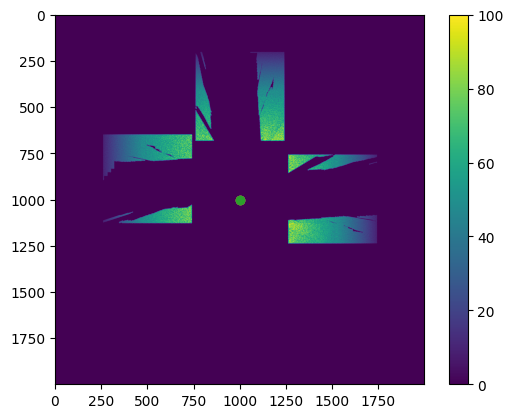

In [27]:
dx = 55
mapgrande = np.zeros((2000, 2000))

for i in range(len(img_seq)):
    t = cv.cvtColor(img_seq[i], cv.COLOR_RGB2GRAY)
    binary_mask = (100 * (np.ones_like(t) - (t==150).astype(np.uint8)) * ponderator).astype(np.uint8)
    update_map(binary_mask, mapgrande, (1000, 1000 - i*dx, i * 90))
    # plt.scatter(1000 + i*dx, 1000 - i*dx)
    plt.scatter(1000, 1000)

plt.imshow(mapgrande)
plt.colorbar()